# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
- Where and when do major power outages tend to occur?
- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?
- What characteristics are associated with each category of cause?
- How have characteristics of major power outages changed over time? Is there a clear trend?

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
TODO

### Cleaning and EDA
TODO

### Assessment of Missingness
TODO

### Hypothesis Test
TODO

# Code

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import util
import folium
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [4]:
# Load data
cols = (['OBS', 'YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
         'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME',
         'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED']) # NERC.REGION, HURRICANE.NAMES
fp = os.path.join('data', 'outage.xlsx')
df = pd.read_excel(fp, header=0, skiprows=[0, 1, 2, 3, 4, 6])[cols] # Load dataframe for my use, skip unuseful rows
df.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED
0,1,2011,7.0,Minnesota,MN,East North Central,-0.3,normal,2011-07-01,17:00:00,2011-07-03,20:00:00,severe weather,NaN,3060.0,NaN,70000.0
1,2,2014,5.0,Minnesota,MN,East North Central,-0.1,normal,2014-05-11,18:38:00,2014-05-11,18:39:00,intentional attack,vandalism,1.0,NaN,NaN
2,3,2010,10.0,Minnesota,MN,East North Central,-1.5,cold,2010-10-26,20:00:00,2010-10-28,22:00:00,severe weather,heavy wind,3000.0,NaN,70000.0
3,4,2012,6.0,Minnesota,MN,East North Central,-0.1,normal,2012-06-19,04:30:00,2012-06-20,23:00:00,severe weather,thunderstorm,2550.0,NaN,68200.0
4,5,2015,7.0,Minnesota,MN,East North Central,1.2,warm,2015-07-18,02:00:00,2015-07-19,07:00:00,severe weather,NaN,1740.0,250.0,250000.0


In [5]:
# Combine date and time into datetime
df['OUTAGE.START'] = (df['OUTAGE.START.DATE'] + 
                      pd.to_timedelta(df['OUTAGE.START.TIME'].astype(str))) # Combine START into date
df['OUTAGE.RESTORATION'] = (df['OUTAGE.RESTORATION.DATE'] +
                            pd.to_timedelta(df['OUTAGE.RESTORATION.TIME'].astype(str))) # Combine RESTORATION into date
outage = df.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME',
                          'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME']) # Drop columns
outage.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,OUTAGE.START,OUTAGE.RESTORATION
0,1,2011,7.0,Minnesota,MN,East North Central,-0.3,normal,severe weather,NaN,3060.0,NaN,70000.0,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2,2014,5.0,Minnesota,MN,East North Central,-0.1,normal,intentional attack,vandalism,1.0,NaN,NaN,2014-05-11 18:38:00,2014-05-11 18:39:00
2,3,2010,10.0,Minnesota,MN,East North Central,-1.5,cold,severe weather,heavy wind,3000.0,NaN,70000.0,2010-10-26 20:00:00,2010-10-28 22:00:00
3,4,2012,6.0,Minnesota,MN,East North Central,-0.1,normal,severe weather,thunderstorm,2550.0,NaN,68200.0,2012-06-19 04:30:00,2012-06-20 23:00:00
4,5,2015,7.0,Minnesota,MN,East North Central,1.2,warm,severe weather,NaN,1740.0,250.0,250000.0,2015-07-18 02:00:00,2015-07-19 07:00:00


In [6]:
# plot US State grouped: when and where

In [7]:
# Maybe need to check the missingness before analysis
major_outage = (outage[(outage['DEMAND.LOSS.MW'] > 300) & # Firm load loss > 300MW
                       (outage['CUSTOMERS.AFFECTED'] > 50000)] # Customers > 50000
                       .reset_index(drop=True)) # Reset index
major_outage.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,OUTAGE.START,OUTAGE.RESTORATION
0,41,2011,4.0,Tennessee,TN,Central,-0.5,cold,severe weather,NaN,5054.0,359.0,63000.0,2011-04-04 11:47:00,2011-04-08 00:01:00
1,42,2009,6.0,Tennessee,TN,Central,0.4,normal,severe weather,storm,136.0,860.0,136000.0,2009-06-12 16:37:00,2009-06-12 18:53:00
2,59,2005,9.0,Wisconsin,WI,East North Central,0.0,normal,severe weather,storm,4410.0,600.0,110000.0,2005-09-13 18:30:00,2005-09-16 20:00:00
3,65,2014,6.0,Wisconsin,WI,East North Central,0.0,normal,severe weather,thunderstorm,538.0,424.0,120000.0,2014-06-30 17:55:00,2014-07-01 02:53:00
4,73,2012,6.0,West Virginia,WV,Central,-0.1,normal,severe weather,thunderstorm,9576.0,700.0,265000.0,2012-06-29 18:24:00,2012-07-06 10:00:00


In [40]:
major_outage['U.S._STATE'].unique()

array(['Tennessee', 'Wisconsin', 'West Virginia', 'Michigan', 'Texas',
       'Indiana', 'Alabama', 'Illinois', 'Washington', 'Arizona',
       'Maryland', 'Pennsylvania', 'Kentucky', 'Utah', 'Ohio',
       'North Carolina', 'New Jersey', 'South Carolina', 'Oregon',
       'District of Columbia', 'Iowa', 'New York', 'Louisiana', 'Florida',
       'California', 'Arkansas', 'Virginia', 'Nebraska', 'New Mexico',
       'Georgia', 'Oklahoma', 'Massachusetts', 'Kansas', 'Hawaii'],
      dtype=object)

In [43]:
count = major_outage.groupby('POSTAL.CODE').count()['DEMAND.LOSS.MW'].reset_index()
count.head()

,POSTAL.CODE,DEMAND.LOSS.MW
0,AL,1
1,AR,2
2,AZ,3
3,CA,16
4,DC,1


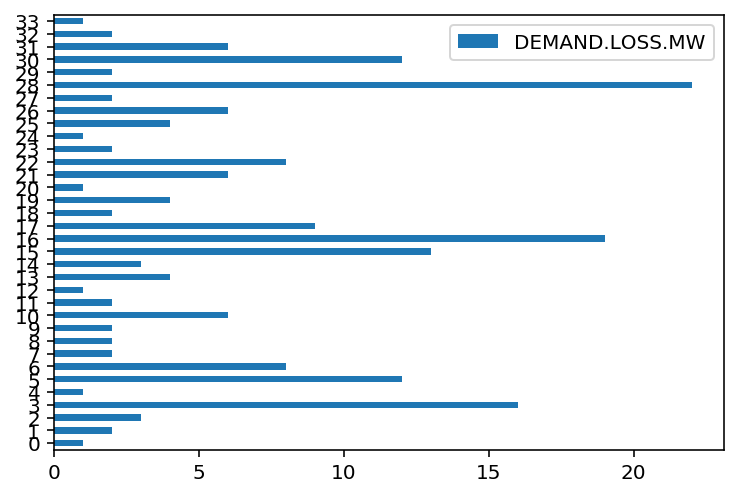

In [46]:
count.plot(kind='barh')

In [42]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

bins = list(major_outage['DEMAND.LOSS.MW'].quantile([0, 0.25, 0.5, 0.75, 1]))

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    # data=major_outage,
    # data=outage,
    data=temp,
    columns=['POSTAL.CODE', 'DEMAND.LOSS.MW'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Demand Loss (MW)',
    # bins=bins,
    reset=True
).add_to(m)

m

### Assessment of Missingness

In [7]:
outage.isnull().mean()

OBS                      0.000000
YEAR                     0.000000
MONTH                    0.005867
U.S._STATE               0.000000
POSTAL.CODE              0.000000
CLIMATE.REGION           0.003911
ANOMALY.LEVEL            0.005867
CLIMATE.CATEGORY         0.005867
CAUSE.CATEGORY           0.000000
CAUSE.CATEGORY.DETAIL    0.307040
OUTAGE.DURATION          0.037810
DEMAND.LOSS.MW           0.459583
CUSTOMERS.AFFECTED       0.288787
OUTAGE.START             0.005867
OUTAGE.RESTORATION       0.037810
dtype: float64

YEAR 0.0
MONTH 0.124
U.S._STATE 0.0
POSTAL.CODE 0.0
CLIMATE.REGION 0.0
ANOMALY.LEVEL 0.037
CLIMATE.CATEGORY 0.327
CAUSE.CATEGORY 0.0
CAUSE.CATEGORY.DETAIL 0.0
OUTAGE.DURATION 0.337
CUSTOMERS.AFFECTED 0.075
OUTAGE.START 0.0
OUTAGE.RESTORATION 0.0


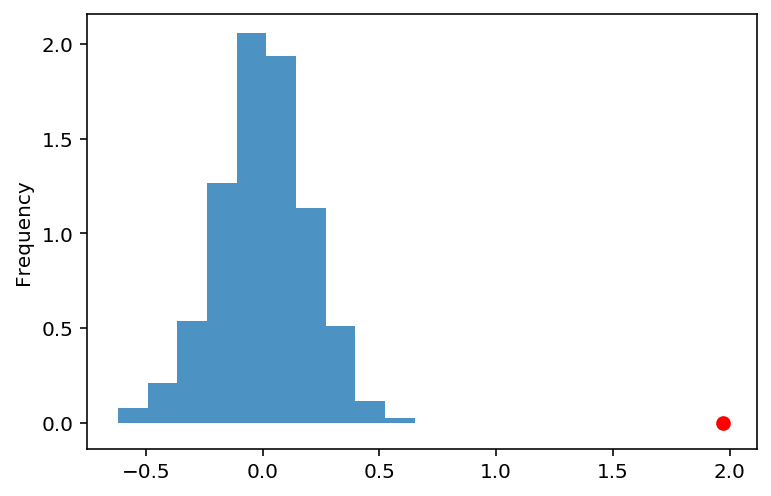

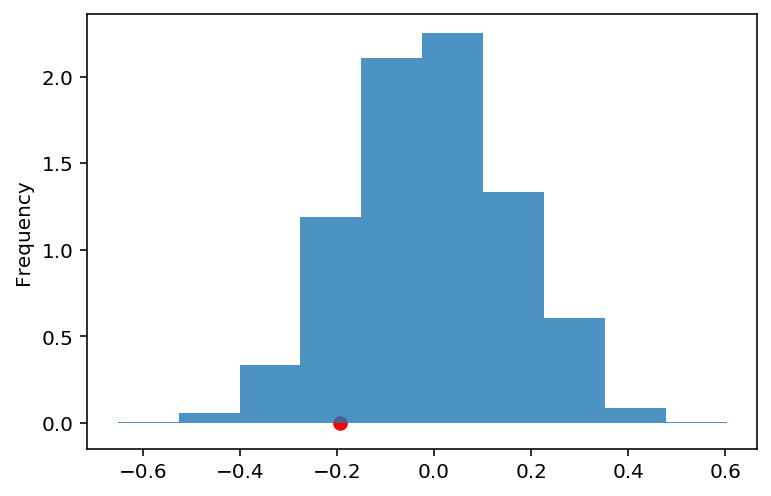

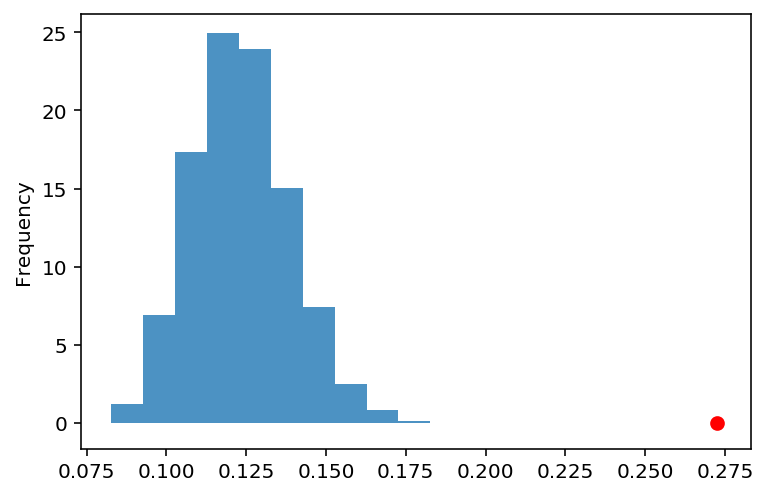

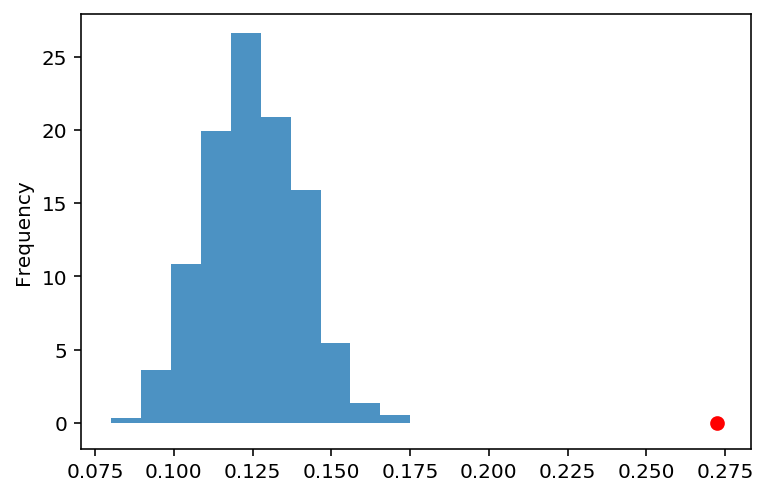

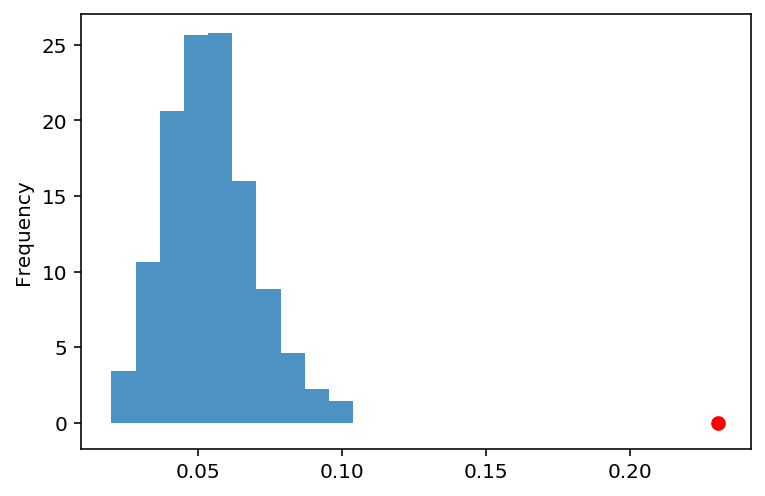

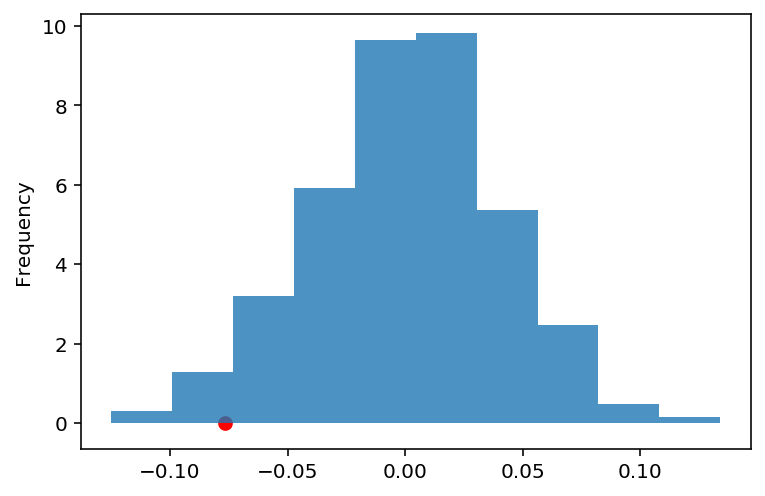

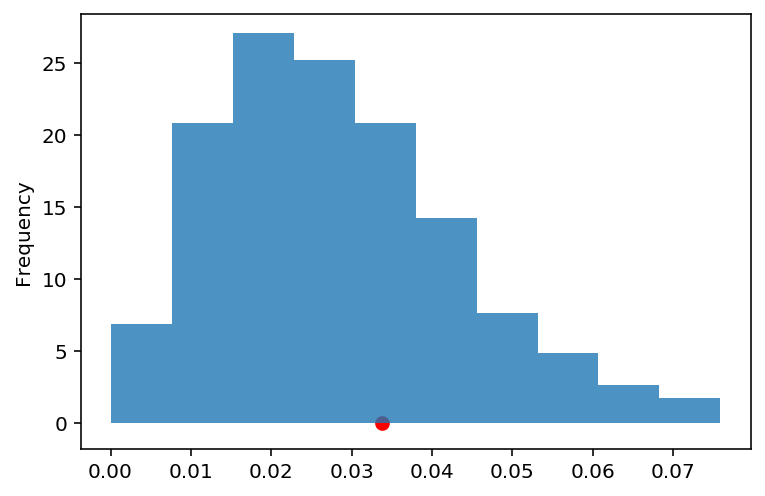

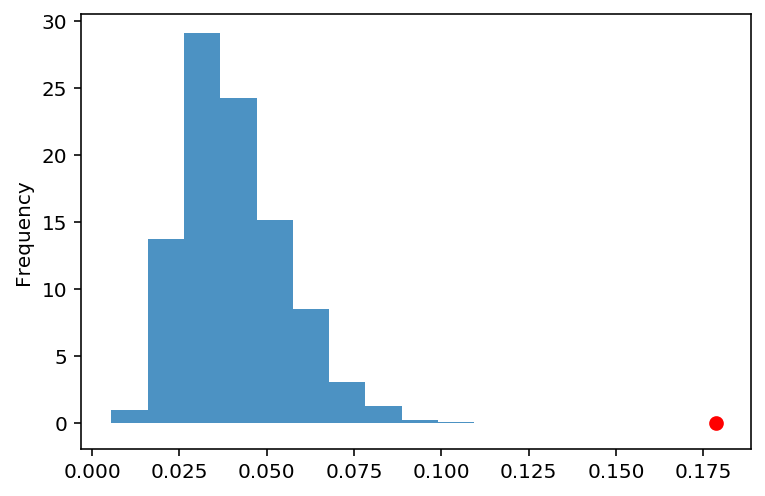

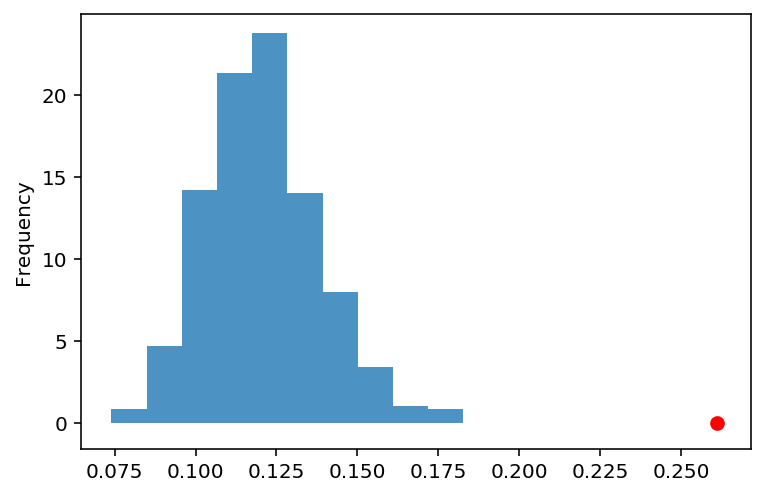

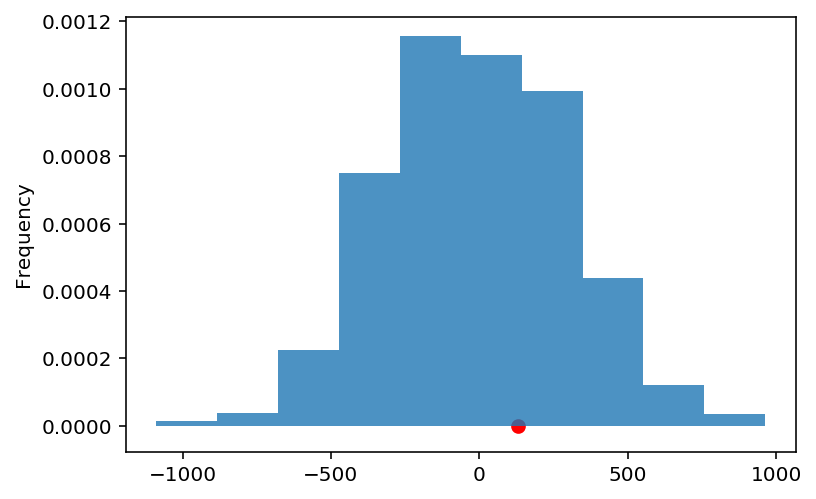

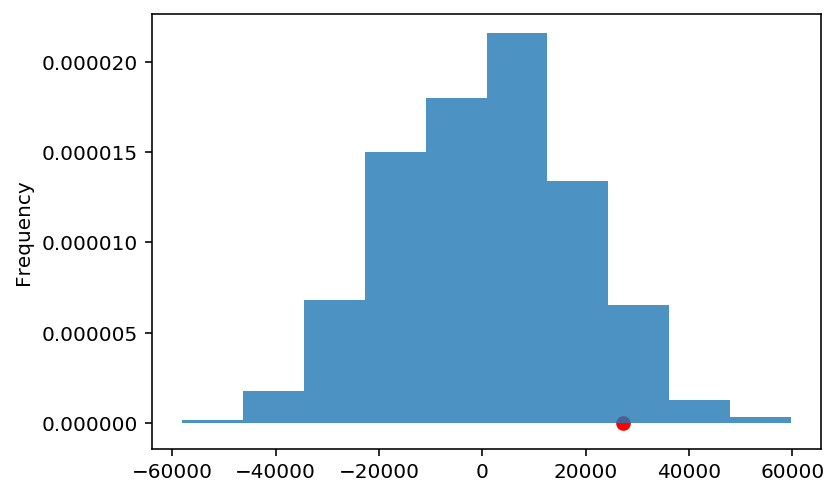

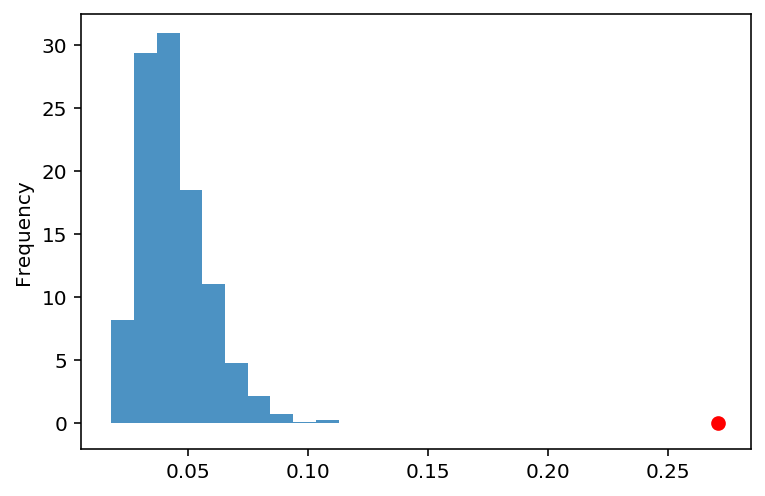

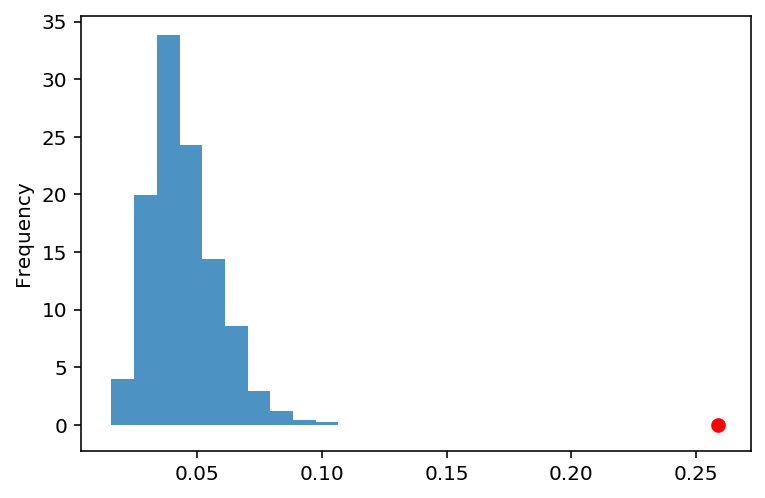

In [36]:
# Missingness of Demand Loss
demand_miss = outage.assign(DEMAND_IS_NULL=outage['DEMAND.LOSS.MW'].isnull())
cols = outage.columns.drop(['OBS','DEMAND.LOSS.MW']) # Columns to check
N = 1000 # Number of Trials
for i in range(len(cols)): # Check missingness
    col = cols[i] # Get the columns
    
    # Different cols have different functions
    if demand_miss[col].dtype == int or demand_miss[col].dtype == float: # Number type
        func = util.diff_in_means # Difference in means
        stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                        col, 'DEMAND_IS_NULL', # Dep col, check col
                                        func, N)) # Function, trials
        print(col, np.min([np.count_nonzero(np.array(stats) <= obs) / N, 
                     np.count_nonzero(np.array(stats) >= obs) / N])) # P-value
    
    elif demand_miss[col].dtype == object: # String Type
        func = util.tvd # Total Variation Distance
        stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                        col, 'DEMAND_IS_NULL', # Dep col, check col
                                        func, N)) # Function, trials
        print(col, np.count_nonzero(np.array(stats) >= obs) / N) # P-value
        
    else: # Datetime continuous category type
        func = util.ks # KS statistic
        stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                        col, 'DEMAND_IS_NULL', # Dep col, check col
                                        func, N)) # Function, trials
        print(col, np.count_nonzero(np.array(stats) >= obs) / N) # P-value
    
    util.plot_distribution(stats, obs, i)
    # print(np.count_nonzero(np.array(stats) compare obs) / 1000) # P-value
    # util.plot_distribution(stats, obs, i)

YEAR 0.0
MONTH 0.0
U.S._STATE 0.0
POSTAL.CODE 0.0
CLIMATE.REGION 0.0
ANOMALY.LEVEL 0.001
CLIMATE.CATEGORY 0.334
CAUSE.CATEGORY 0.0
CAUSE.CATEGORY.DETAIL 0.0
OUTAGE.DURATION 0.003
DEMAND.LOSS.MW 0.0
OUTAGE.START 0.0
OUTAGE.RESTORATION 0.0


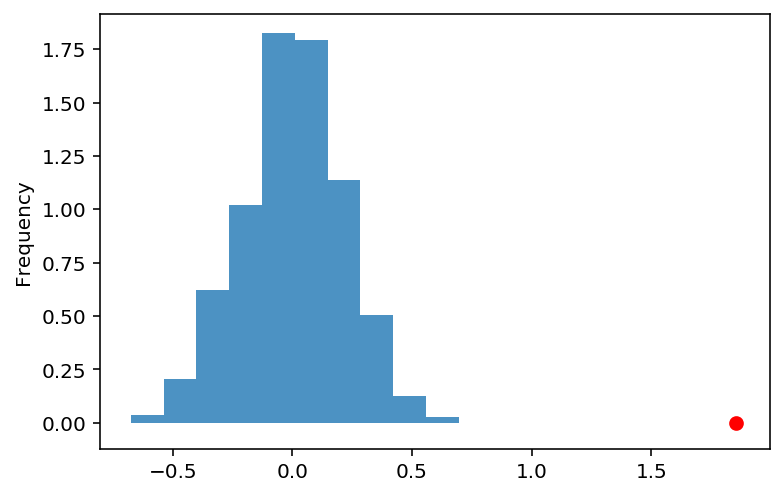

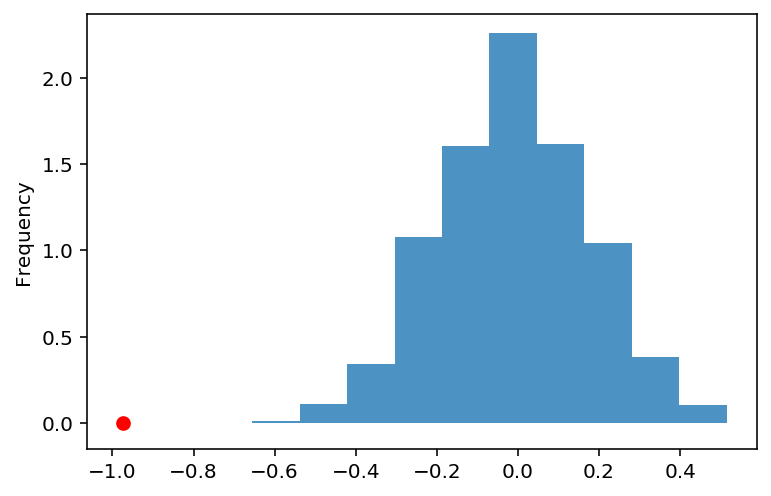

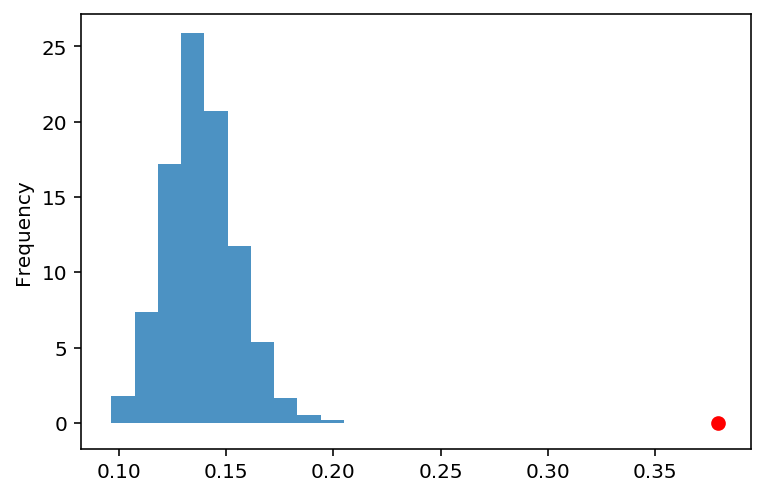

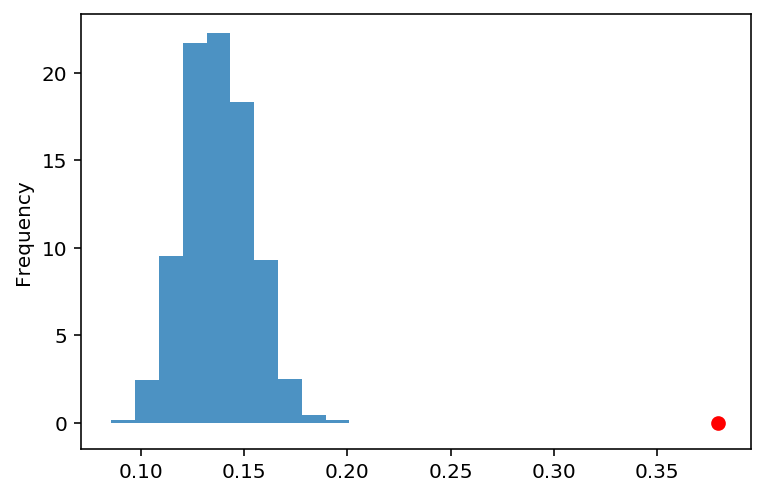

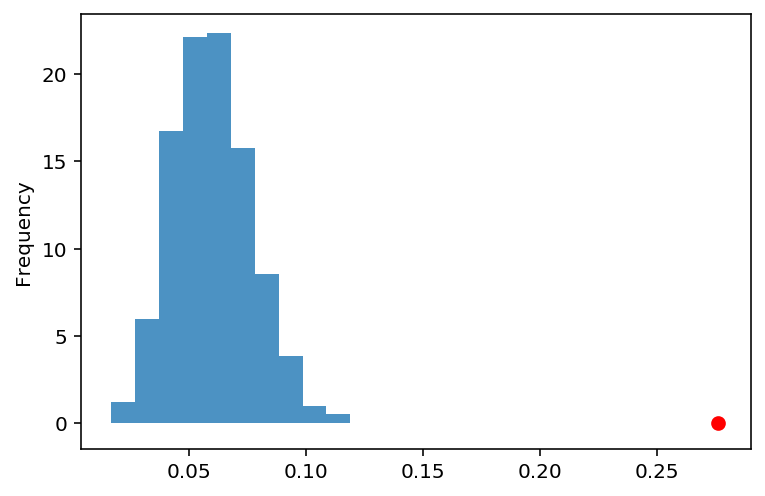

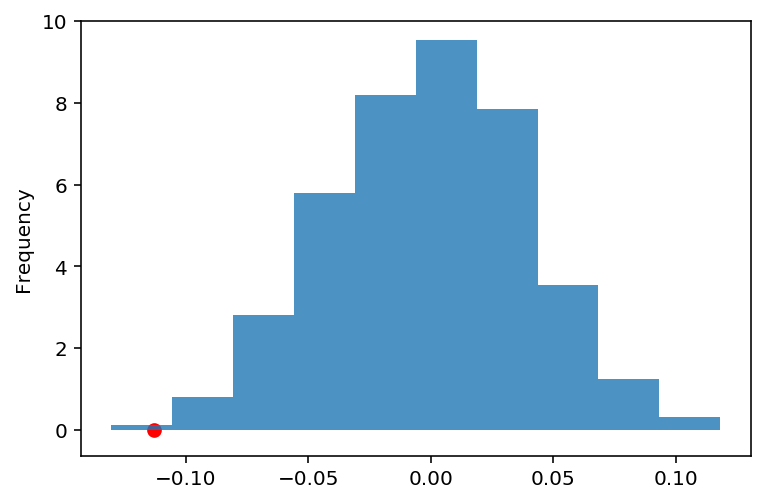

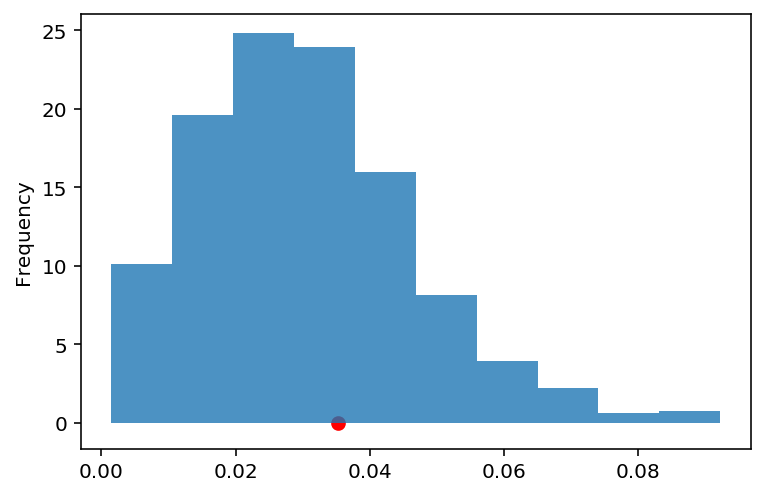

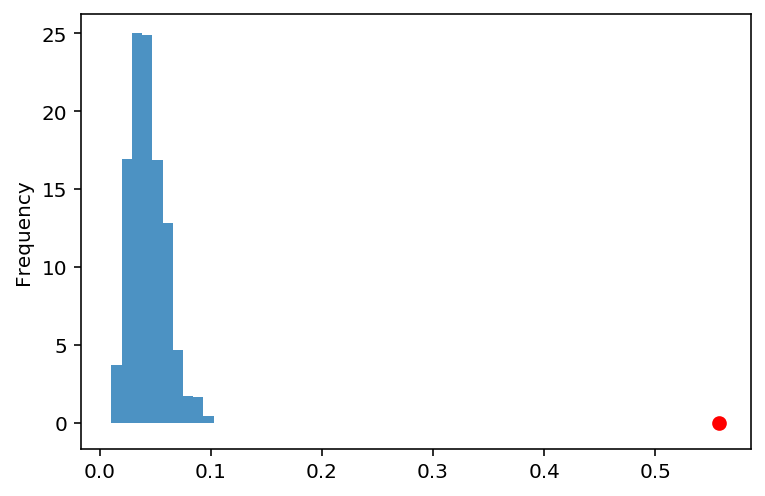

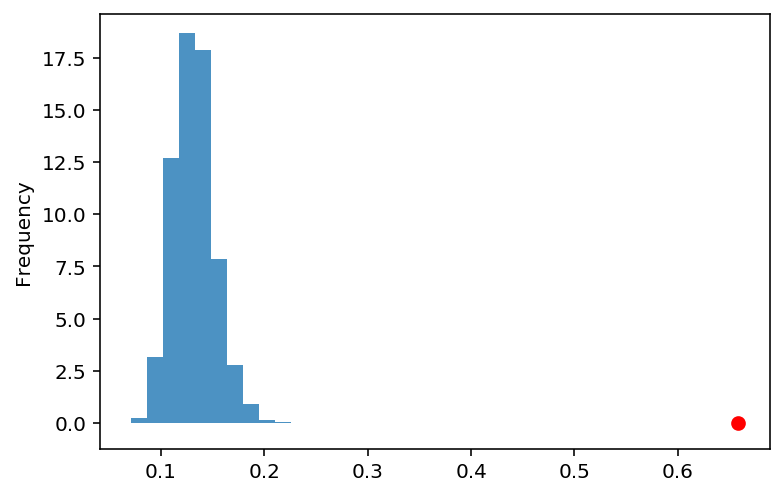

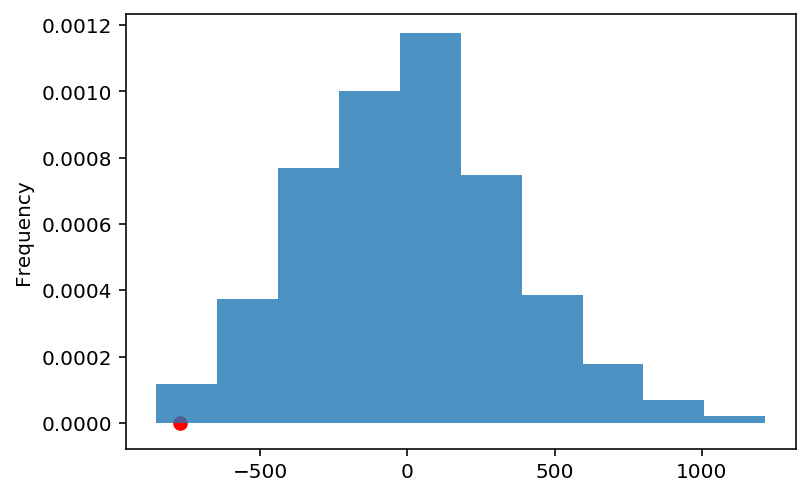

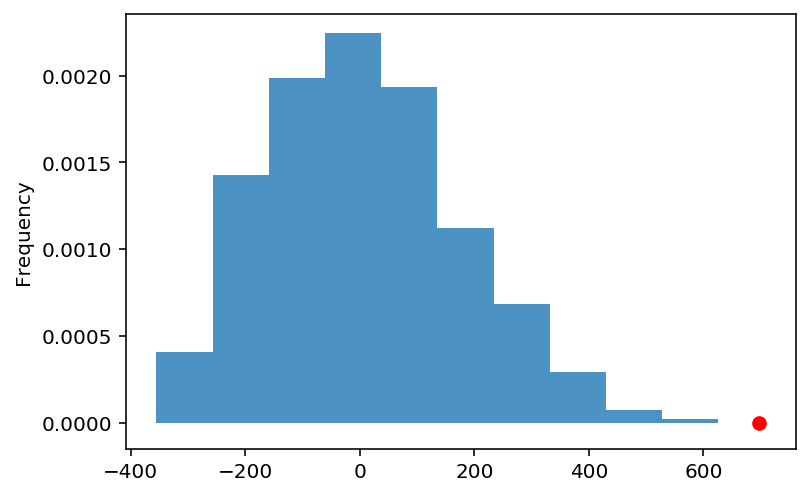

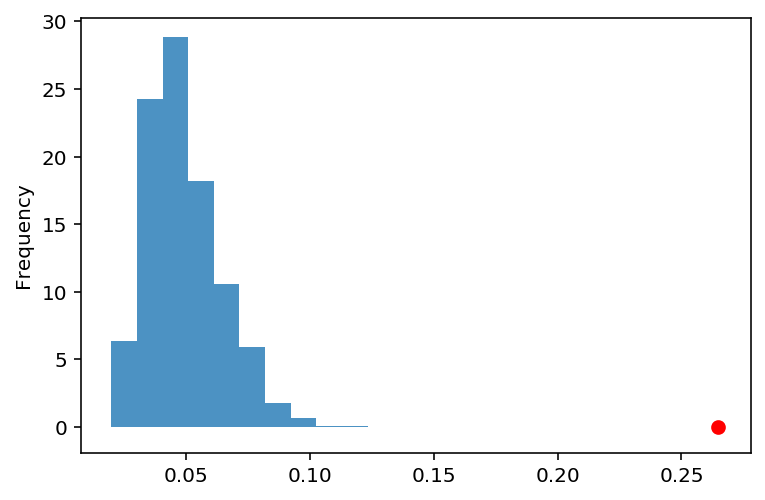

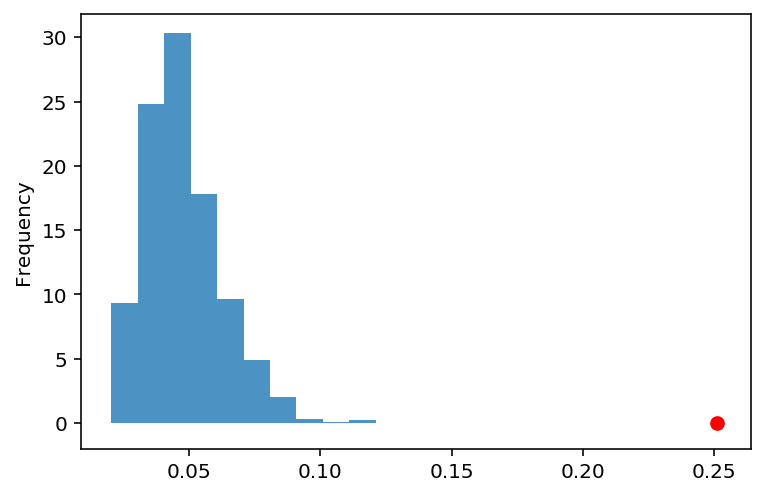

In [10]:
# Missingness of Customers Affected
demand_miss = outage.assign(CUS_IS_NULL=outage['CUSTOMERS.AFFECTED'].isnull())
cols = outage.columns.drop(['OBS','CUSTOMERS.AFFECTED']) # Columns to check
N = 1000 # Number of Trials
for i in range(len(cols)): # Check missingness
    col = cols[i] # Get the columns
    
    # Different cols have different functions
    if demand_miss[col].dtype == int or demand_miss[col].dtype == float: # Number type
        func = util.diff_in_means # Difference in means
        stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                        col, 'CUS_IS_NULL', # Dep col, check col
                                        func, N)) # Function, trials
        print(col, np.min([np.count_nonzero(np.array(stats) <= obs) / N, 
                     np.count_nonzero(np.array(stats) >= obs) / N])) # P-value
    
    elif demand_miss[col].dtype == object: # String Type
        func = util.tvd # Total Variation Distance
        stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                        col, 'CUS_IS_NULL', # Dep col, check col
                                        func, N)) # Function, trials
        print(col, np.count_nonzero(np.array(stats) >= obs) / N) # P-value
        
    else: # Datetime continuous category type
        func = util.ks # KS statistic
        stats, obs = (util.permutation_test(demand_miss, # Perform permutation test
                                        col, 'CUS_IS_NULL', # Dep col, check col
                                        func, N)) # Function, trials
        print(col, np.count_nonzero(np.array(stats) >= obs) / N) # P-value
    
    util.plot_distribution(stats, obs, i)


### Hypothesis Test

In [ ]:
# TODO